<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a1/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a1/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assigment 1 execution

Corpora: https://www.nltk.org/nltk_data/ , point 91, "Dependency Parsed Treebank" ([link](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip)).

Docs:
* https://www.nltk.org/api/nltk.corpus.html
* https://www.nltk.org/data.html
* https://www.nltk.org/install.html

## Preparing the environment

In [1]:
%pip install pandas numpy matplotlib gensim tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os, shutil  #  file management
import sys 
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import re
import urllib.request  # download files
from zipfile import ZipFile # extract files
from matplotlib import pyplot as plt
import tensorflow_addons as tfa

## Downloading the dataset

In [3]:
#from nltk import download
#download()

In [4]:
dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")
    
with ZipFile(dataset_path, 'r') as zObject:
  # Extracting all the members of the zip  into a specific location.
  zObject.extractall(dataset_folder)
  print("Successful extraction")

Successful extraction


## Loading the data

In [5]:
#from nltk.corpus import dependency_treebank
#from nltk.data import load
#dependency_treebank_test = load("nltk:") 
#sentences = dependency_treebank.sents()
#words = dependency_treebank.words()

In [6]:
def loadCorpus(start, stop=None):
    '''
    Loads the data for the specified file range.
    
    Removes the third column 'num', which is not necessary for this task.

    Parameters:
        start: start of numeric range of files (inclusive)
        stop: end of numeric range of files (exclusive)
    '''
    dataset_name = "dependency_treebank"
    folder = os.path.join(os.getcwd(), "Dataset", dataset_name)

    if stop==None:
        stop = start+1
    
    return pd.concat([
        pd.read_csv(
            f'{folder}/wsj_{"{:04d}".format(num)}.dp',
            sep="\t",
            usecols=[0,1],
            names=["word","label"]
        ) for num in range(start, stop)
    ])

In [7]:
full_dataset = loadCorpus(1,200)

## Exploratory Data Analysis

In [8]:
full_dataset.count()

word     94084
label    94084
dtype: int64

In [9]:
full_dataset.head(10)

,word,label
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


Each document contains a different tokenized article:

In [10]:
" ".join(loadCorpus(1)["word"])

'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .'

In [11]:
" ".join(loadCorpus(2)["word"])

'Rudolph Agnew , 55 years old and former chairman of Consolidated Gold Fields PLC , was named a nonexecutive director of this British industrial conglomerate .'

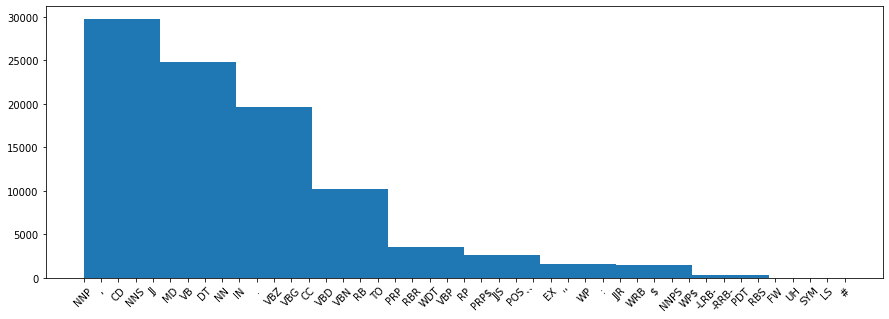

In [12]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(full_dataset["label"])
plt.xticks(rotation=45)
plt.show()

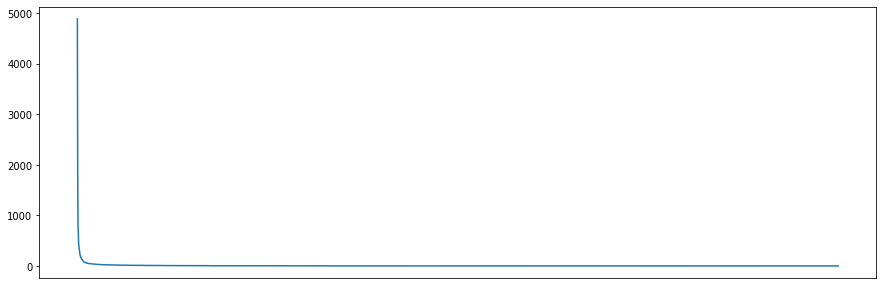

In [13]:
fig=plt.figure(figsize=(15,5))
p = plt.plot(full_dataset["word"].value_counts())
plt.xticks([])
plt.show()

## Data splitting





Creation of train, validation and test sets.

In [14]:
df_train = loadCorpus(1,101) 
df_val = loadCorpus(101,151)
df_test = loadCorpus(151,200)

df_train.count()

word     47356
label    47356
dtype: int64

In [15]:
df_val.count()

word     31183
label    31183
dtype: int64

In [16]:
df_test.count()

word     15545
label    15545
dtype: int64

## Data pre-processing

Clean the data.

In [17]:
def cleanCorpus(corpus):
    corpus['word'] = corpus['word'].str.lower()
    corpus["word"] = [re.sub(r'[^\w]', '', word) for word in corpus["word"]]
    corpus = corpus[corpus["word"] != ""]
    return corpus

In [18]:
#cleaned dataframes
dfc_train = cleanCorpus(df_train)
dfc_val = cleanCorpus(df_val)
dfc_test = cleanCorpus(df_test)

dfc_train.count()

word     41149
label    41149
dtype: int64

In [19]:
dfc_val.count()

word     27263
label    27263
dtype: int64

In [20]:
dfc_test.count()

word     13614
label    13614
dtype: int64

In [21]:
dfc_train.head(10)

,word,label
0,pierre,NNP
1,vinken,NNP
3,61,CD
4,years,NNS
5,old,JJ
7,will,MD
8,join,VB
9,the,DT
10,board,NN
11,as,IN


## Word embedding

### Loading GloVe


Loading pre-trained dense word embedding: Glove.






In [22]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [23]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
# Fasttext -> 300
embedding_model = load_embedding_model(model_type="glove", embedding_dimension=50)

### Analyzing OOV statistics

In [24]:
embedding_model.index_to_key[0:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [25]:
oov_train = list(set([word for word in dfc_train.word.values if word not in embedding_model.index_to_key]))
oov_val = list(set([word for word in dfc_val.word.values if word not in embedding_model.index_to_key]))

len(oov_train)

535

In [26]:
len(oov_val)

305

In [27]:
oov_train[0:10]

['landonne',
 '264590',
 'jerseybased',
 '3527',
 'multibilliondollar',
 'eightcount',
 'oldhouse',
 'subsegments',
 'automotiveparts',
 'foodshop']

### Embedding with GloVe

#### Prepare the embedding matrix

Definition of a tokenizer.

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

# define the tokenizer
tokenizer = Tokenizer(oov_token='<unk>')
text = dfc_train.word.values

#fit the tokenizer on the training data
tokenizer.fit_on_texts(text)

# number of unique words in dict.
print("Number of unique words in dictionary=", len(tokenizer.word_index))
print("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:10]))
with open('./word_index.json','w') as word_index_file:
    word_index_file.write(tokenizer.to_json())

Number of unique words in dictionary= 7305
Dictionary head:  {'<unk>': 1, 'the': 2, 'of': 3, 'a': 4, 'to': 5, 'in': 6, 'and': 7, 'for': 8, 's': 9, 'that': 10}


Define the embedding matrix.

In [29]:
from tqdm import tqdm

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx,
                           vocab_size: int) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(tokenizer.word_index.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            #print(f"Using random vector for '{word}'")
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [30]:
# Testing
embedding_dimension = 50
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index, vocab_size )
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 7305/7305 [00:00<00:00, 285833.88it/s]

Embedding matrix shape: (7306, 50)


#### Encode the dataset

Define a label encoder for the target class.

In [31]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
dfc_val['encoded_label'] = le.transform(dfc_val['label'])
dfc_test['encoded_label'] = le.transform(dfc_test['label'])

<ipython-input-31-ba113b02b22f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
<ipython-input-31-ba113b02b22f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_val['encoded_label'] = le.transform(dfc_val['label'])
<ipython-input-31-ba113b02b22f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [32]:
dfc_train.head(10)

,word,label,encoded_label
0,pierre,NNP,16
1,vinken,NNP,16
3,61,CD,5
4,years,NNS,18
5,old,JJ,10
7,will,MD,14
8,join,VB,29
9,the,DT,6
10,board,NN,15
11,as,IN,9


Transform the text into a sequence of integers using the tokenizer defined before. 

In [33]:
x_train = np.array(tokenizer.texts_to_sequences(dfc_train.word.values)) 
y_train =np.array( dfc_train['encoded_label'])

x_val = np.array(tokenizer.texts_to_sequences(dfc_val.word.values))
y_val = np.array(dfc_val['encoded_label'])

x_test = np.array(tokenizer.texts_to_sequences(dfc_test.word.values))
y_test = np.array(dfc_test['encoded_label'])

#number of unique labels
num_classes = len(np.unique(y_train))
num_classes


39

In [34]:

vocab_size = len(tokenizer.word_index) + 1
vocab_size

7306

Pad the sequences to make them of same length before passing them to the model.

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=1, padding='post')
x_val = pad_sequences(x_val, maxlen=1, padding='post')
x_test = pad_sequences(x_test, maxlen=1, padding='post')

#Train
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')
print(f'type:{type(x_train)}')

# Val
print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')
print(f'type:{type(y_train)}')
# Test

print(f'X test shape: {x_test.shape}', x_test.shape)
print(f'Y test shape: {y_test.shape}', y_test.shape)

X train shape: (41149, 1)
Y train shape: (41149,)
type:<class 'numpy.ndarray'>
X val shape: (27263, 1)
Y val shape: (27263,)
type:<class 'numpy.ndarray'>
X test shape: (13614, 1) (13614, 1)
Y test shape: (13614,) (13614,)


## Baseline model: LSTM

### Define the model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 

model = Sequential()
embedding_layer = Embedding(input_dim = vocab_size,output_dim= embedding_dimension,input_length=1, weights = [embedding_matrix], trainable = False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(32)))
model.add(Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 50)             365300    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               21248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 39)                2535      
                                                                 
Total params: 389,083
Trainable params: 23,783
Non-trainable params: 365,300
_________________________________________________________________


In [37]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [38]:
# fit model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 64, epochs=30)

Epoch 1/30
643/643 [==============================] - 9s 8ms/step - loss: 1.8510 - accuracy: 0.5273 - val_loss: 1.3286 - val_accuracy: 0.6278
Epoch 2/30
643/643 [==============================] - 4s 5ms/step - loss: 1.0282 - accuracy: 0.7100 - val_loss: 1.0798 - val_accuracy: 0.6749
Epoch 3/30
643/643 [==============================] - 3s 5ms/step - loss: 0.8496 - accuracy: 0.7539 - val_loss: 0.9791 - val_accuracy: 0.7100
Epoch 4/30
643/643 [==============================] - 3s 5ms/step - loss: 0.7542 - accuracy: 0.7824 - val_loss: 0.9243 - val_accuracy: 0.7250
Epoch 5/30
643/643 [==============================] - 3s 5ms/step - loss: 0.6888 - accuracy: 0.7990 - val_loss: 0.8884 - val_accuracy: 0.7221
Epoch 6/30
643/643 [==============================] - 3s 5ms/step - loss: 0.6405 - accuracy: 0.8110 - val_loss: 0.8600 - val_accuracy: 0.7343
Epoch 7/30
643/643 [==============================] - 4s 6ms/step - loss: 0.6027 - accuracy: 0.8215 - val_loss: 0.8397 - val_accuracy: 0.7443
Epoch 

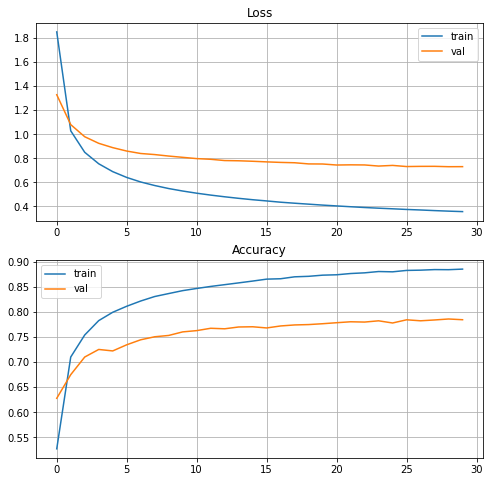

In [39]:
plt.figure(figsize=(8,8))

plt.subplot(211)
plt.grid(True)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()


plt.subplot(212)
plt.grid(True)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

plt.show()

In [40]:
model.evaluate(x_val, y_val)

852/852 [==============================] - 2s 3ms/step - loss: 0.7303 - accuracy: 0.7842


[0.7302950024604797, 0.7842130064964294]

### F1-Macro evaluation

In [41]:
#predictions on the test data
y_pred = model.predict(x_test)

426/426 [==============================] - 2s 2ms/step


In [42]:
n = np.shape(y_pred)[0]
score = [np.argmax(y_pred[x,:]) for x in range(0,n)]

In [48]:
from sklearn.metrics import f1_score, accuracy_score
f1 = f1_score(y_test, score, average ='macro')
print(f'F1_score is: {f1}')

F1_score is: 0.7483586341161695


In [44]:
y_val.shape

(27263,)

In [45]:
onehot = OneHotEncoder(sparse=False)
onehot.fit(y_train.reshape(-1,1))
y_val_onehot = onehot.transform(y_val.reshape(-1,1))
y_val_onehot.shape

(27263, 39)

In [46]:
y_pred_val = model.predict(x_val)
y_pred_val.shape

852/852 [==============================] - 2s 2ms/step


(27263, 39)

In [47]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
f1_macro = tfa.metrics.F1Score(average="macro", num_classes=num_classes, threshold=0.5)
f1_macro.update_state(y_val_onehot, y_pred_val)
f1_macro.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.66066504>

## Model A: GRU

GRU is a simpler alternative to LSTM's architecture, less effective but with a faster train.
</br>Two layers architecture: a Bidirectional GRU layer and a Dense/FC layer on top. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU, Bidirectional

gru_model = Sequential()
embedding_layer = Embedding(input_dim = vocab_size, 
                            output_dim = embedding_dimension, 
                            input_length = 1,
                            weights = [embedding_matrix],
                            trainable = False)

gru_model.add(embedding_layer)
gru_model.add(Bidirectional(GRU(32)))
gru_model.add(Dense(num_classes, activation='softmax'))

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 50)             365300    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16128     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 39)                2535      
                                                                 
Total params: 383,963
Trainable params: 18,663
Non-trainable params: 365,300
_________________________________________________________________


In [ ]:
## From Tutorial 2
## A simple plot function, could be used in any model to avoid redundancy

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from functools import partial
import random
from keras.callbacks import History

def show_history(history: History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy

gru_model.compile(optimizer=Adam(learning_rate=1e-3), 
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

In [ ]:
history = gru_model.fit(x=x_train, y=y_train, 
                        validation_data=(x_val,y_val),
                        verbose=1,
                        epochs=30,
                        batch_size=64)

Epoch 1/30
643/643 [==============================] - 3s 2ms/step - loss: 1.7098 - sparse_categorical_accuracy: 0.5463 - val_loss: 1.2780 - val_sparse_categorical_accuracy: 0.6337
Epoch 2/30
643/643 [==============================] - 1s 2ms/step - loss: 1.0048 - sparse_categorical_accuracy: 0.7085 - val_loss: 1.1033 - val_sparse_categorical_accuracy: 0.6712
Epoch 3/30
643/643 [==============================] - 1s 2ms/step - loss: 0.8509 - sparse_categorical_accuracy: 0.7487 - val_loss: 1.0230 - val_sparse_categorical_accuracy: 0.7012
Epoch 4/30
643/643 [==============================] - 1s 2ms/step - loss: 0.7606 - sparse_categorical_accuracy: 0.7766 - val_loss: 0.9652 - val_sparse_categorical_accuracy: 0.7291
Epoch 5/30
643/643 [==============================] - 1s 2ms/step - loss: 0.6972 - sparse_categorical_accuracy: 0.7948 - val_loss: 0.9276 - val_sparse_categorical_accuracy: 0.7238
Epoch 6/30
643/643 [==============================] - 1s 2ms/step - loss: 0.6490 - sparse_categorica

Displaying the following history keys: dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


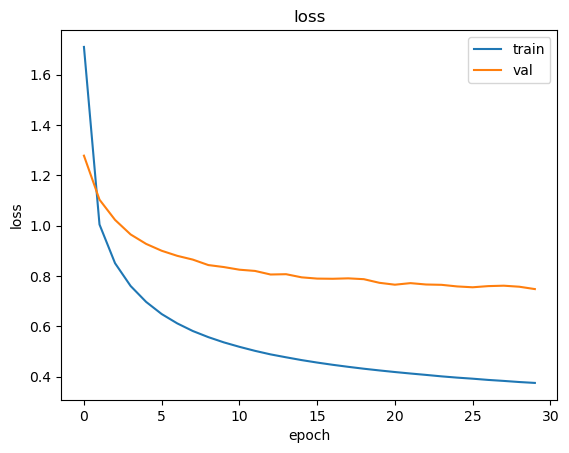

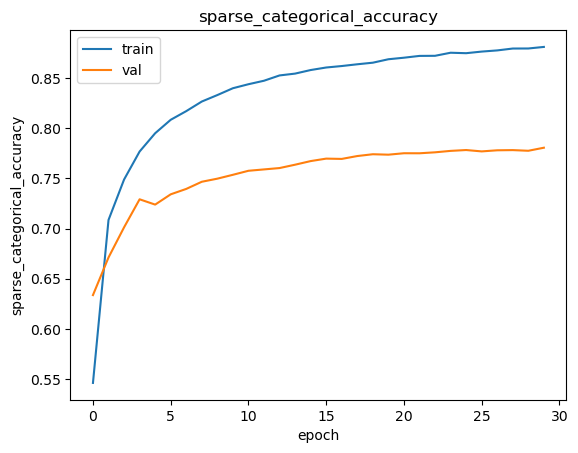

In [ ]:
show_history(history)

## Model B: 2x LSTM 

## Model C: LSTM + Dense

## Conclusions